In [4]:
!pip install ucimlrepo
!pip install imblearn

### Installing  Required Libraries

In [5]:
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from dataclasses import dataclass

### Import data

In [6]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
room_occupancy_estimation = fetch_ucirepo(id=864)
room_occupancy_df = pd.concat([room_occupancy_estimation.data.features, room_occupancy_estimation.data.targets], axis=1)

### EDA


In [7]:
room_occupancy_df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [8]:
room_occupancy_df.columns

Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')

In [9]:
room_occupancy_df.shape

(10129, 19)

In [10]:
room_occupancy_df.dtypes

Date                     object
Time                     object
S1_Temp                 float64
S2_Temp                 float64
S3_Temp                 float64
S4_Temp                 float64
S1_Light                  int64
S2_Light                  int64
S3_Light                  int64
S4_Light                  int64
S1_Sound                float64
S2_Sound                float64
S3_Sound                float64
S4_Sound                float64
S5_CO2                    int64
S5_CO2_Slope            float64
S6_PIR                    int64
S7_PIR                    int64
Room_Occupancy_Count      int64
dtype: object

In [11]:
room_occupancy_df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


In [12]:
# checking for null values

def find_null_percent(df):

    # creating a data frame with percent of null values in each column
    null_percent = (df.isnull().mean()*100).reset_index().rename(columns = {'index': 'column_name', 0:'percent_of_null_values'})
    return null_percent

find_null_percent(room_occupancy_df)

,column_name,percent_of_null_values
0,Date,0.0
1,Time,0.0
2,S1_Temp,0.0
3,S2_Temp,0.0
4,S3_Temp,0.0
5,S4_Temp,0.0
6,S1_Light,0.0
7,S2_Light,0.0
8,S3_Light,0.0
9,S4_Light,0.0


In [13]:
room_occupancy_df.dtypes

Date                     object
Time                     object
S1_Temp                 float64
S2_Temp                 float64
S3_Temp                 float64
S4_Temp                 float64
S1_Light                  int64
S2_Light                  int64
S3_Light                  int64
S4_Light                  int64
S1_Sound                float64
S2_Sound                float64
S3_Sound                float64
S4_Sound                float64
S5_CO2                    int64
S5_CO2_Slope            float64
S6_PIR                    int64
S7_PIR                    int64
Room_Occupancy_Count      int64
dtype: object

In [14]:
room_occupancy_df["Date"] = pd.to_datetime(room_occupancy_df["Date"])
room_occupancy_df["Time"] = pd.to_timedelta(room_occupancy_df["Time"])

In [15]:
room_occupancy_df.dtypes

Date                     datetime64[ns]
Time                    timedelta64[ns]
S1_Temp                         float64
S2_Temp                         float64
S3_Temp                         float64
S4_Temp                         float64
S1_Light                          int64
S2_Light                          int64
S3_Light                          int64
S4_Light                          int64
S1_Sound                        float64
S2_Sound                        float64
S3_Sound                        float64
S4_Sound                        float64
S5_CO2                            int64
S5_CO2_Slope                    float64
S6_PIR                            int64
S7_PIR                            int64
Room_Occupancy_Count              int64
dtype: object

In [16]:
room_occupancy_df['Datetime'] = room_occupancy_df["Date"] + room_occupancy_df["Time"]
# Extracting hour of the day
room_occupancy_df['Hour_of_day'] = room_occupancy_df['Datetime'].dt.hour
# Extracting day of the week (Monday= 0 and Sunday=6)
room_occupancy_df['Day_of_week'] = room_occupancy_df['Datetime'].dt.dayofweek

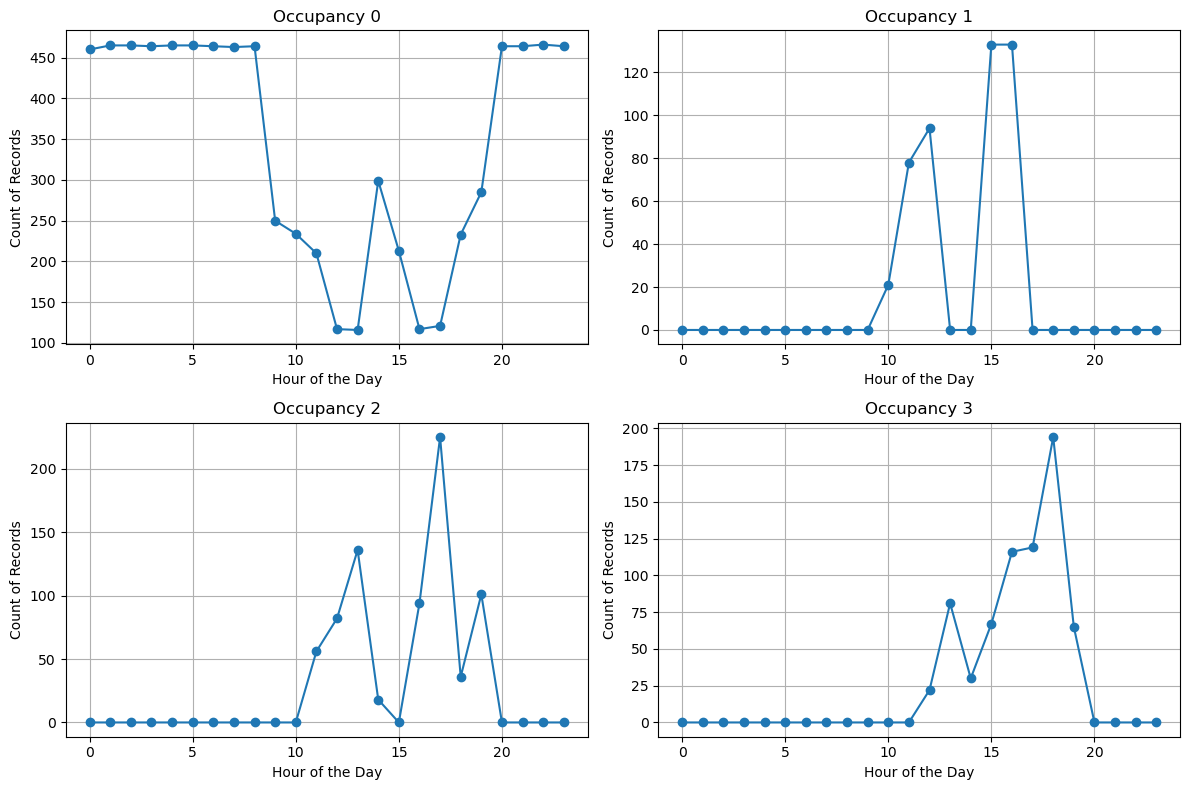

In [17]:
pivot_table = room_occupancy_df.pivot_table(index='Hour_of_day', columns='Room_Occupancy_Count', aggfunc='size', fill_value=0)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    col = pivot_table.columns[i]
    ax.plot(pivot_table.index, pivot_table[col], marker='o')
    ax.set_title(f'Occupancy {col}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Count of Records')
    ax.grid(True)

plt.tight_layout()
plt.show()

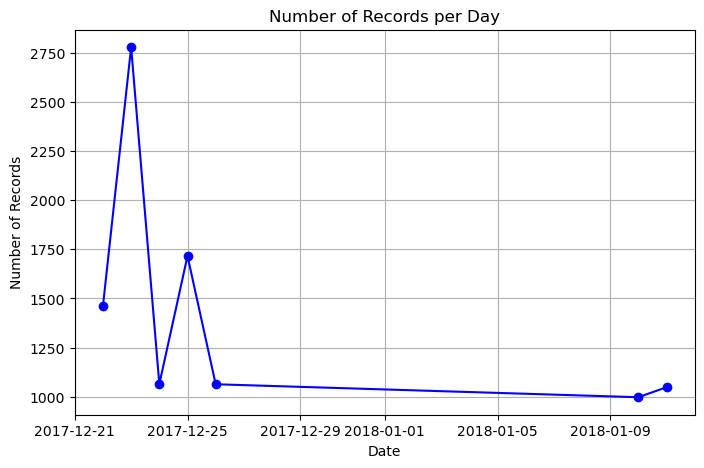

In [18]:
# Group by date and count the number of records for each day
daily_counts = room_occupancy_df.groupby('Date').size().reset_index(name='count')

plt.figure(figsize=(8, 5))
plt.plot(daily_counts['Date'], daily_counts['count'], marker='o', linestyle='-', color='b')
plt.title('Number of Records per Day')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.grid(True)
plt.show()

In [19]:
# Function to categorize time of day
def categorize_time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Extracting hour from datetime column and apply categorize_time_of_day function
room_occupancy_df['time_of_day'] = room_occupancy_df['Datetime'].dt.hour.apply(categorize_time_of_day)

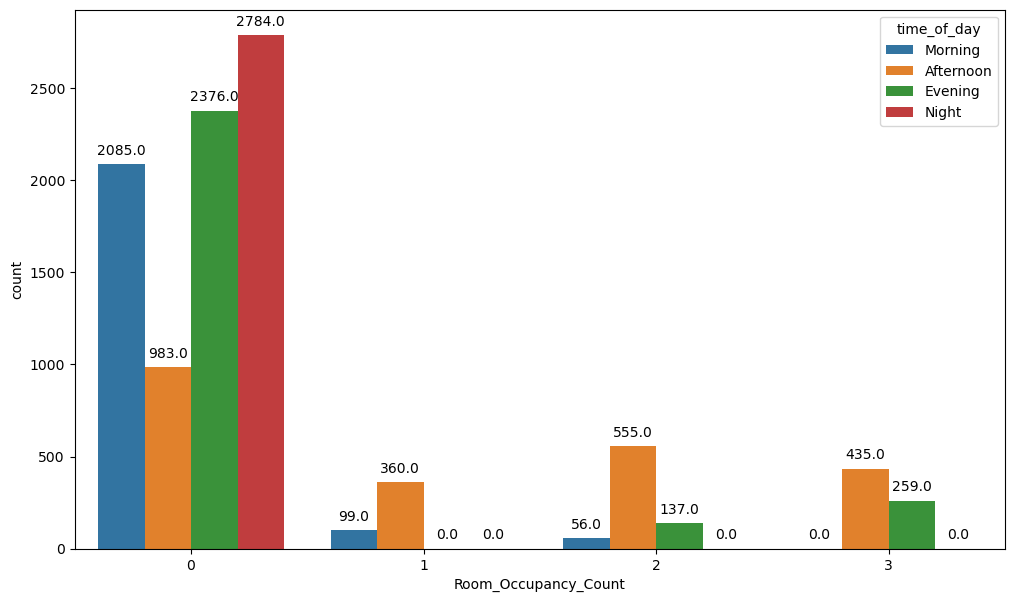

In [20]:
#Classification of records based on time of day
plt.figure(figsize=(12,7))
ax = sns.countplot(data = room_occupancy_df,x = 'Room_Occupancy_Count', hue = 'time_of_day', hue_order = ['Morning','Afternoon','Evening','Night'])
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

## Reasons for dropping 'Date' and 'Time' column's

- As we have seen in the graph that there 0 data values for class 0 during Afternoon, Evening, Morning and alot of values for Night only. For our learning purposes we don't want that to effect of hour of day to skew the results.
- Also, as we can see that hour of day, day, month, year(features extracted from date and time) have no impact on  data. We would prefer dropping 'Date' and 'Time'
-Since, number of records on different days is highly varying we don’t want it to affect our learning

In [21]:
room_occupancy_df= room_occupancy_df.drop(columns=['Date', 'Time', 'Datetime', 'Hour_of_day', 'Day_of_week','time_of_day'])

In [22]:
# checking for duplicate rows
room_occupancy_df.drop_duplicates(inplace=True)

In [23]:
room_occupancy_df.shape

(8828, 17)

In [24]:
room_occupancy_df.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count'],
      dtype='object')

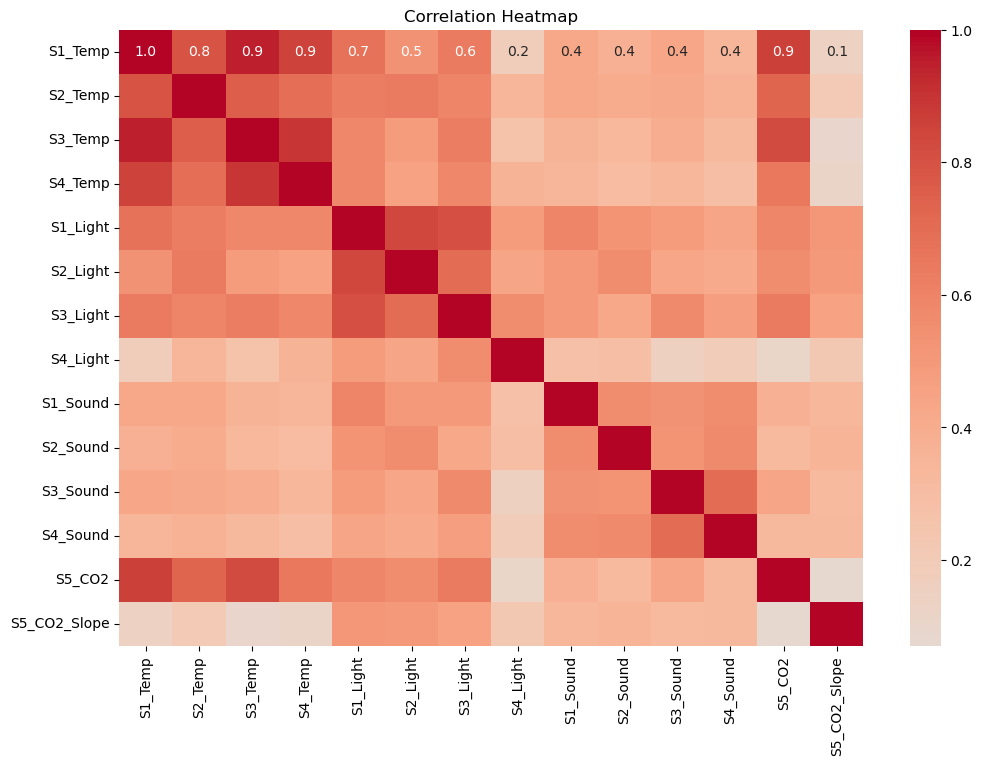

In [25]:
numerical_columns = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp','S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
                     'S5_CO2', 'S5_CO2_Slope']
# Checking correlation between features
corr_matrix = room_occupancy_df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".1f")
plt.title('Correlation Heatmap')
plt.show()

In [26]:
# Dropping features with correlation greater than 0.9
room_occupancy_df = room_occupancy_df.drop([ 'S3_Temp', 'S4_Temp','S5_CO2'],axis=1)

In [27]:
room_occupancy_df.shape

(8828, 14)

In [28]:
room_occupancy_df.columns

Index(['S1_Temp', 'S2_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light',
       'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2_Slope',
       'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count'],
      dtype='object')

### Checking for Outliers

In [29]:
numerical_columns = ['S1_Temp', 'S2_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2_Slope']

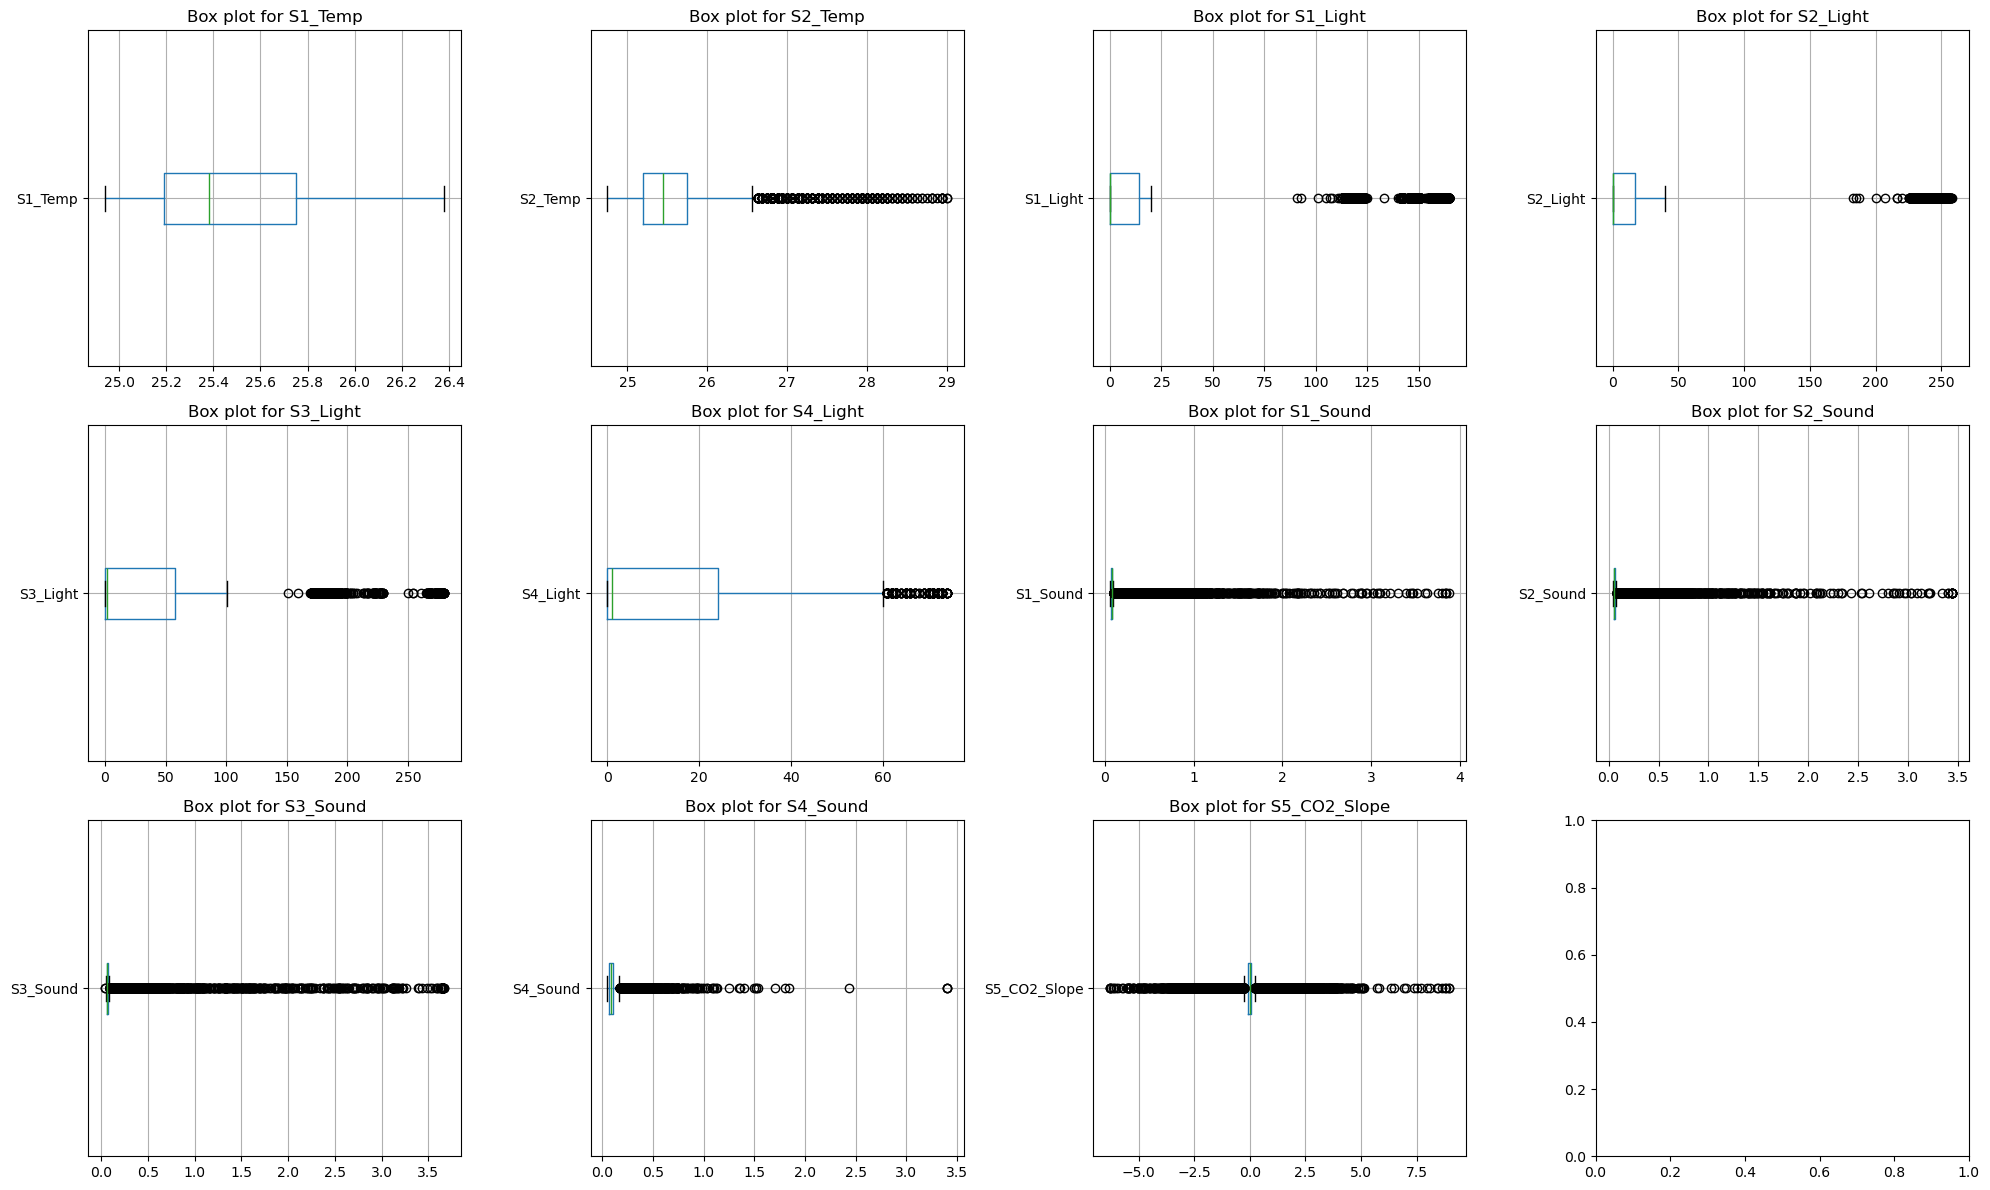

In [30]:
# Using box-plot
n_cols = 4
n_rows = 3

# Create a figure with subplots in a 4x4 grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through all columns and create a box plot in each subplot
for i, column in enumerate(numerical_columns):
    if i < n_cols * n_rows:  # Check if the current index is within the range of available subplots
        room_occupancy_df.boxplot(column=[column], vert=False, ax=axes[i])  # Create box plot
        axes[i].set_title(f"Box plot for {column}")  # Set title to the name of the column
    else:
        break  # Exit the loop if there are more columns than subplots available

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

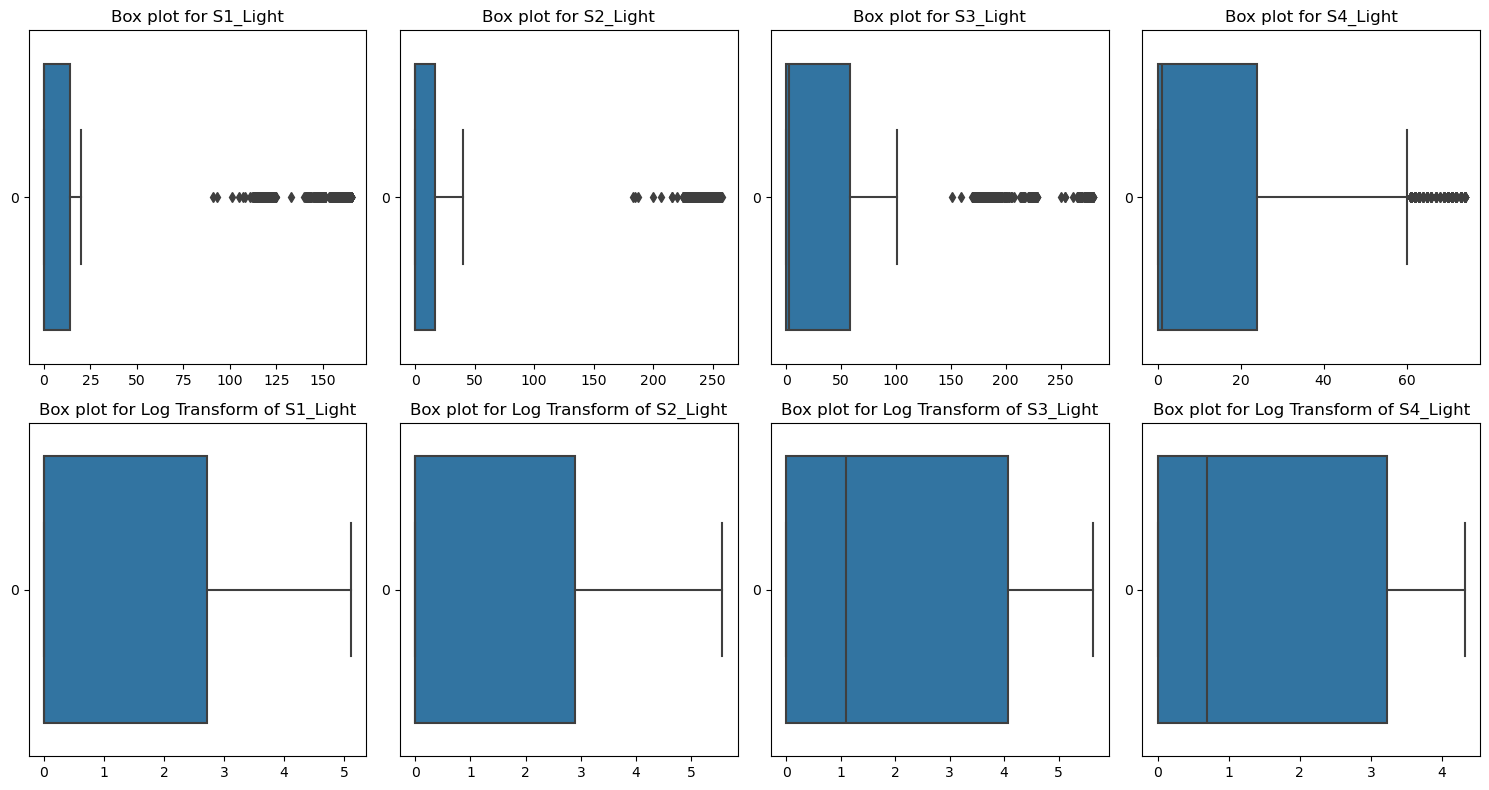

In [31]:
# Determine the number of rows and columns for the subplot grid
n_cols = 4
n_rows = 2

# Create a figure with subplots in a 4x4 grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through all columns and create a box plot in each subplot
for i, column in enumerate(['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']):
    sns.boxplot(data= (room_occupancy_df[column]), ax = axes[i], orient = 'h')  # Create box plot
    axes[i].set_title(f"Box plot for {column}")  # Set title to the name of the column

# Loop through all columns and create a box plot in each subplot
for i, column in enumerate(['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']):
    sns.boxplot(data= np.log(room_occupancy_df[column]+1), ax = axes[i+4], orient = 'h')  # Create box plot
    axes[i+4].set_title(f"Box plot for Log Transform of {column}")  # Set title to the name of the column

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [32]:
light_features = ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']

# Applying Box-Cox transformation
for feature in light_features:
    log_values = np.log(room_occupancy_df[feature]+1)
    room_occupancy_df[f'{feature}_log'] = log_values


In [33]:
room_occupancy_df.columns

Index(['S1_Temp', 'S2_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light',
       'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2_Slope',
       'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count', 'S1_Light_log',
       'S2_Light_log', 'S3_Light_log', 'S4_Light_log'],
      dtype='object')

### Checking if features follow a Gaussian distribution

/Users/omii/anaconda3/envs/Lab_1_7300/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/omii/anaconda3/envs/Lab_1_7300/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/omii/anaconda3/envs/Lab_1_7300/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/omii/anaconda3/envs/Lab_1_7300/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

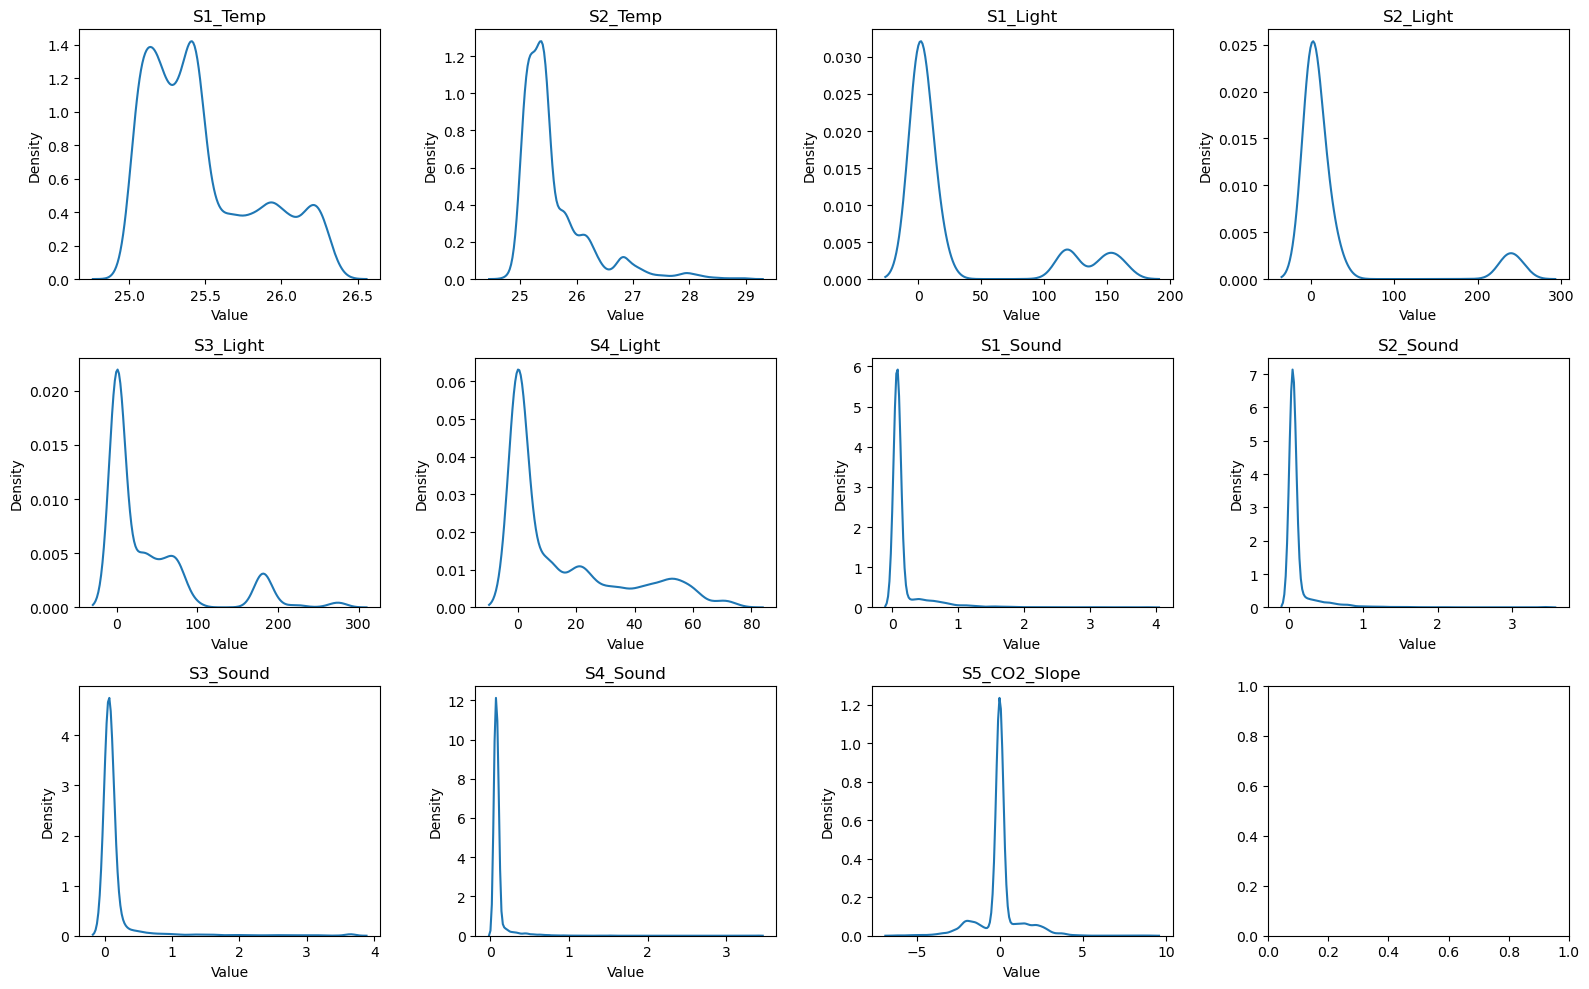

In [34]:
features = ['S1_Temp', 'S2_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light',
            'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2_Slope']

# Generate density plots for each feature
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    sns.kdeplot(room_occupancy_df[feature], ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.grid(False)

plt.tight_layout()
plt.show()

All sound feature have left skewness but still follow a normal distribution

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


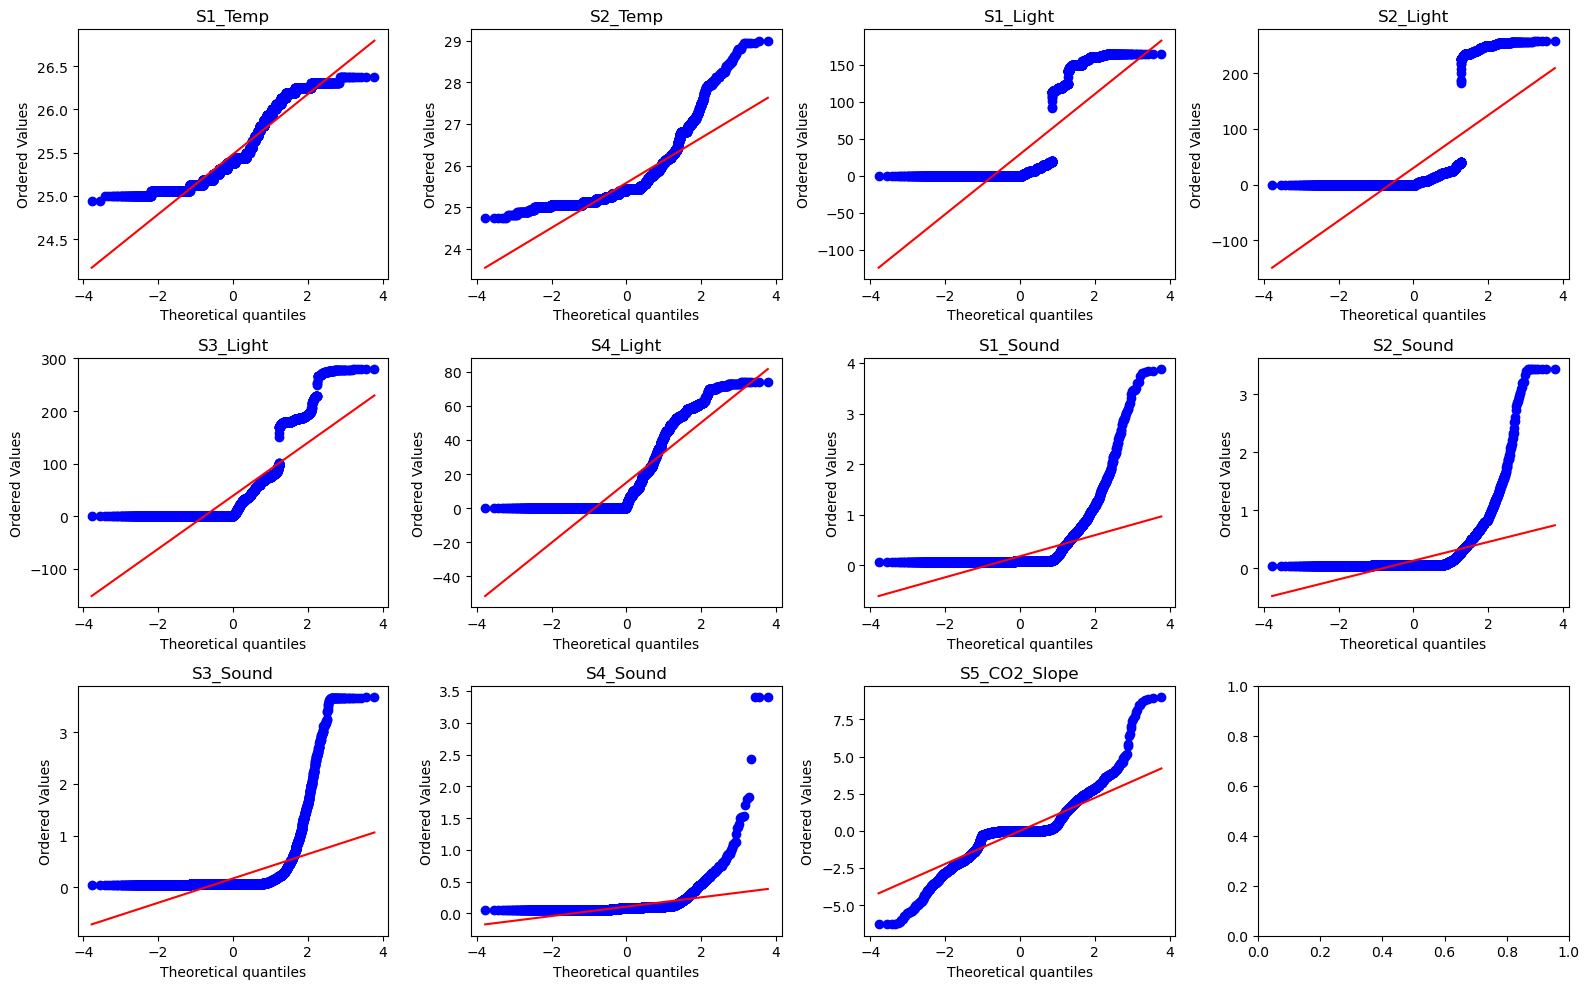

In [35]:
# Flatten axes if necessary
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

# Generate Q-Q plots for each feature
for i, feature in enumerate(features):
    ax = axes[i]
    stats.probplot(room_occupancy_df[feature], dist="norm", plot=ax)
    ax.set_title(feature)
    ax.set_xlabel('Theoretical quantiles')
    ax.set_ylabel('Ordered Values')

plt.tight_layout()
plt.show()

In [36]:
from scipy.stats import boxcox
sound_features = ['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']

# Applying Box-Cox transformation
for feature in sound_features:
    box_cox_data, lambda_value = boxcox(room_occupancy_df[feature] + 1)
    room_occupancy_df[f'{feature}_boxcox'] = box_cox_data

/Users/omii/anaconda3/envs/Lab_1_7300/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/omii/anaconda3/envs/Lab_1_7300/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/omii/anaconda3/envs/Lab_1_7300/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/omii/anaconda3/envs/Lab_1_7300/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

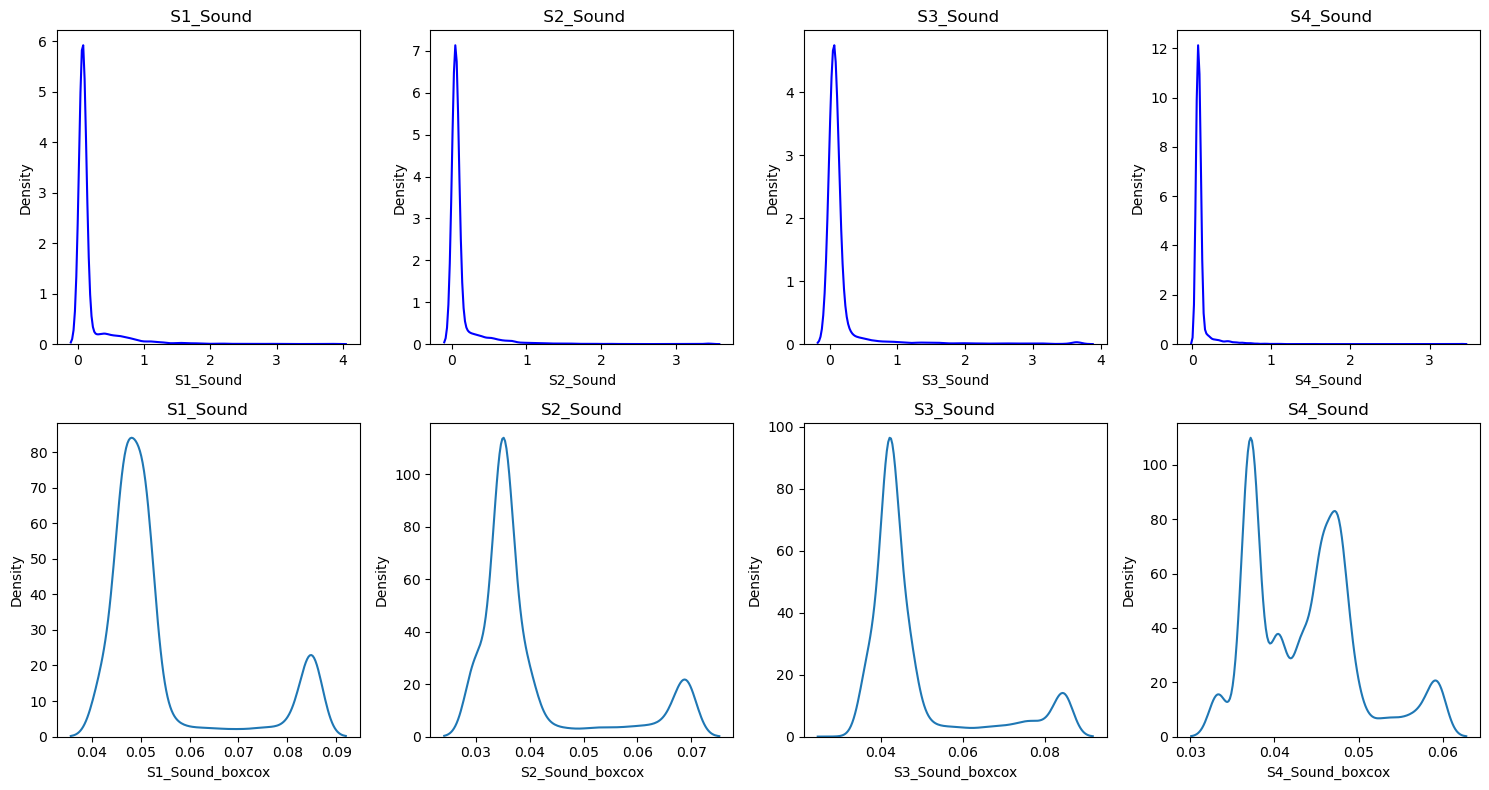

In [37]:
n_cols = 4
n_rows = 2

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through all columns and create a density plot in each subplot
for i, column in enumerate(sound_features):
    sns.kdeplot(room_occupancy_df[column], ax=axes[i], color='blue')
    axes[i].set_title(f" {column}")

# Loop through all columns and create a density plot of the Box-Cox transformed features in each subplot
for i, column in enumerate(sound_features):
    sns.kdeplot(room_occupancy_df[f'{column}_boxcox'], ax=axes[i+4])
    axes[i+4].set_title(f"{column}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()




*   After different transformations 'S2_Temp' still had many outliers, so we are dropping it. It also had high corelation with 'S1_Temp'.
*   'S1_Sound_boxcox', 'S2_Sound_boxcox', 'S3_Sound_boxcox' follow Gaussian distribution but 'S4_Sound_boxcox' still does not. So we will drop S4_Sound feature.

*   We are also dropping 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light' as we created their transformed form using log transformation, which removed outliers.



In [38]:
room_occupancy_df= room_occupancy_df.drop(['S2_Temp','S1_Light', 'S2_Light', 'S3_Light', 'S4_Light',  'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound'], axis=1)

In [39]:
room_occupancy_df.columns

Index(['S1_Temp', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count',
       'S1_Light_log', 'S2_Light_log', 'S3_Light_log', 'S4_Light_log',
       'S1_Sound_boxcox', 'S2_Sound_boxcox', 'S3_Sound_boxcox',
       'S4_Sound_boxcox'],
      dtype='object')

# Splitting the data

In [40]:
X = room_occupancy_df.drop(['Room_Occupancy_Count'], axis=1)
y = room_occupancy_df['Room_Occupancy_Count']

In [41]:
X.head()

,S1_Temp,S5_CO2_Slope,S6_PIR,S7_PIR,S1_Light_log,S2_Light_log,S3_Light_log,S4_Light_log,S1_Sound_boxcox,S2_Sound_boxcox,S3_Sound_boxcox,S4_Sound_boxcox
0,24.94,0.769231,0,0,4.804021,3.555348,3.988984,3.713572,0.050729,0.063703,0.042149,0.037168
1,24.94,0.646154,0,0,4.804021,3.526361,3.988984,3.713572,0.085399,0.035033,0.042149,0.037168
2,25.00,0.519231,0,0,4.804021,3.555348,3.988984,3.713572,0.084139,0.053949,0.050589,0.037168
3,25.00,0.388462,0,0,4.804021,3.555348,3.988984,3.713572,0.083906,0.051803,0.057249,0.045545
4,25.00,0.253846,0,0,4.804021,3.555348,4.007333,3.713572,0.073126,0.039417,0.042149,0.037168


### SMOTE on train data

In [42]:
def oversample_minority_classes(X, y):
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

X_resampled, y_resampled = oversample_minority_classes(X, y)

print(X_resampled.shape)

(27708, 12)


### Split into test and training data

In [43]:
trainX, testX, trainY, testY = train_test_split(X_resampled, y_resampled, test_size = 0.20)

In [44]:
def confusion_matrix(y_true, y_pred, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        matrix[int(true), int(pred)] += 1
    return matrix

def precision_recall_accuracy(conf_matrix):
    num_classes = conf_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    for i in range(num_classes):
        true_positives = conf_matrix[i, i]
        false_positives = np.sum(conf_matrix[:, i]) - true_positives
        false_negatives = np.sum(conf_matrix[i, :]) - true_positives
        precision[i] = true_positives / (true_positives + false_positives)
        recall[i] = true_positives / (true_positives + false_negatives)
    return precision, recall, accuracy

# Random Classifier - Baseline

In [45]:
class BaselineClassifier():
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def predict(self):
        return np.random.randint(0, len(np.unique(self.y)) , size=len(self.X))

In [46]:
baseline = BaselineClassifier(X_resampled, y_resampled)

In [47]:
baseline_ = baseline.predict()

In [48]:
conf_matrix = confusion_matrix(testY, baseline_, 4)
precision, recall, accuracy = precision_recall_accuracy(conf_matrix)
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Confusion Matrix:
[[329 381 320 336]
 [343 356 323 384]
 [354 328 351 364]
 [342 329 351 351]]
Precision: [0.24049708 0.2553802  0.26096654 0.2445993 ]
Recall: [0.24084919 0.25320057 0.25125268 0.25564457]
Accuracy: 0.25027066041140383


# Naive Baiyes

In [49]:
class NaiveBayesClassifier:
    def __init__(self):
        """
        Naive Bayes Classifier
        """
        self.classes = None
        self.params = {}

    def fit(self, X, y):
        """
        Fits the Naive Bayes model to the training data by calculating the mean, variance,
        and prior probabilities for each class.

        :param X: the feature data used for training.
        :param y: the target labels corresponding to the rows in X.
        """
        self.classes = np.unique(y)
        total = len(y)
        self.params = {cls: self._estimate_parameters(X[y == cls], total) for cls in self.classes}

    def _estimate_parameters(self, data, total):
        """
        Estimates the mean, variance, and prior probability function

        :param data: data subset for a particular class.
        :return: dict which is a dictionary containing the mean, variance adjusted by a small constant
                (in order to avoid division by zero, and prior probability)
        """
        small_constant = 1e-6
        laplace_smoothing = 1
        k = len(self.classes)
        return {
            'mean': data.mean(),
            'var': data.var() + small_constant,
            'prior': (len(data) + laplace_smoothing) / (total + k)
        }

    def predict(self, X):
        """
        Predicts the class labels function

        :param X: pandas.DataFrame - The feature data for prediction.
        :return: predicted class labels
        """
        return np.array([self._predict_single(row) for index, row in X.iterrows()])

    def _predict_single(self, x):
        """
        Single data point and returns the class with the highest posterior probability

        :param x: a single data point
        :return: the class label with the highest posterior probability
        """
        posteriors = [self._compute_posterior(cls, x) for cls in self.classes]
        return self.classes[np.argmax(posteriors)]

    def _compute_posterior(self, cls, x):
        """
        Computes the posterior probability function

        :param cls: the class label
        :param x: the data point features
        :return: a float value which is log of the posterior probability
        """
        prior = self.params[cls]['prior']
        log_prior = np.log(max(prior, 1e-10))
        conditional = np.sum(np.log(self.prob_density_function(cls, x) + 1e-10))
        return log_prior + conditional

    def prob_density_function(self, cls, x):
        """
        Calculates the probability density function

        :param cls: the class label
        :param x: feature values
        :return: a float value which is the computed probability density
        """
        mean = self.params[cls]['mean']
        var = self.params[cls]['var']
        numerator = np.exp(- (x-mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [50]:
naive_bayes = NaiveBayesClassifier()

In [51]:
naive_bayes.fit(trainX, trainY)

In [52]:
predictions = naive_bayes.predict(testX)

In [53]:
conf_matrix = confusion_matrix(testY, predictions, 4)
precision, recall, accuracy = precision_recall_accuracy(conf_matrix)
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Confusion Matrix:
[[1344    0    0   22]
 [   0 1359   47    0]
 [   2   13 1379    3]
 [  12    0  905  456]]
Precision: [0.98969072 0.99052478 0.59159159 0.94802495]
Recall: [0.98389458 0.96657183 0.98711525 0.33211945]
Accuracy: 0.8188379646337063


# SVM

In [54]:
trainX, testX, trainY, testY = train_test_split(X_resampled, y_resampled, test_size = 0.20)

In [55]:
# Support Vector machine class using gradient descent

class SVM:

    def __init__(self, learning_rate = 0.00001, lambda_ = 0.001, max_iterations = 100, normalize='True'):
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.max_iterations = max_iterations
        self.normalize = normalize

    def add_X0(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    def normalize_testdata(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        X = (X-self.mean) / self.std
        X = self.add_X0(X)
        return X

    def normalize_traindata(self, X):
        X = (X-self.mean) / self.std
        X = self.add_X0(X)
        return X

    def fit(self, X, y):
        #n = X.shape[0]
        #y = np.where(y <= 0, -1, 1)
        if self.normalize:
          X = self.normalize_testdata(X)
        self.w = np.zeros(X.shape[1])
        self.b = 0
        for i in range(0, self.max_iterations):
            for idx, xi in enumerate(X):
                condition = (y[0][idx] * (np.dot(self.w, xi))) + self.b
                if condition >= 1:
                    self.w = self.w - self.learning_rate * (2 * self.lambda_ * np.array(self.w))
                else:

                    self.w = self.w - self.learning_rate * ((2 * self.lambda_ * np.array(self.w))
                                                            - np.dot(xi, y[0][idx]))
                    self.b = self.b - (self.learning_rate * -y[0][idx])


    def predict(self, X):
        if self.normalize:
          X = self.normalize_traindata(X)
        pred = np.dot(X, self.w) + self.b
        return pred

In [56]:
# Class to solve for multi class problem for SVM

class multiclassSolver:

    def __init__(self, X, y, model):
        self.X = X
        self.y = y
        self.model = model

    def fit(self):
        self.weights_array = []
        self.models_array = []
        for i in np.unique(self.y):
            print("Training for target Class", i)
            y_ = pd.DataFrame(np.where(self.y.copy() == i, 1, -1))
            self.models_array.append(copy.copy(self.model))
            weights = self.models_array[-1].fit(self.X, y_)
            #weights = [sub_arr[0] for sub_arr in weights]
            #self.weights_array.append(weights)
        print("Training completed")

    def predict(self, X):
        pred = []
        for i in range (0, len(np.unique(self.y))):
            pred.append(self.models_array[i].predict(X))
        max_indices = np.argmax(pred, axis=0)
        return max_indices



In [57]:
model = SVM()

In [58]:
a = multiclassSolver(trainX, trainY, model)

In [59]:
a.fit()

Training for target Class 0
Training for target Class 1
Training for target Class 2
Training for target Class 3
Training completed


In [60]:
y_ = a.predict(testX)

In [61]:
conf_matrix = confusion_matrix(testY, y_, 4)
precision, recall, accuracy = precision_recall_accuracy(conf_matrix)

print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Confusion Matrix:
[[1313   45    0    8]
 [   0 1385    2   24]
 [   0  306  173  923]
 [   7   34   15 1307]]
Precision: [0.99469697 0.78248588 0.91052632 0.57780725]
Recall: [0.96120059 0.98157335 0.12339515 0.95891416]
Accuracy: 0.7538794658967881


#PCA

In [62]:
def pca_check(X):

  flag=0
  # Checking if all columns are numerical
  if X.select_dtypes(include=np.number).equals(X):
    print("All columns are numerical")
  else:
    flag=1
    print("PCA cannot be performed because all columns are not numerical.")

  # Checking dataset size
  n, d = X.shape
  if d <= n:
    print("Dimensions are appropriate to perform PCA ")
  else:
    flag=1
    print("Dimensions are not appropriate to perform PCA")

  # Checking linearity assumption using SVD

  def svd(X):

    XTX = np.dot(X.T, X)
    eigenvalues, eigenvectors = np.linalg.eigh(XTX)
    sort_indices = np.argsort(eigenvalues)[::-1] # Sort in descending order
    sort_eigenvectors = eigenvectors[:, sort_indices]
    sort_eigenvalues = eigenvalues[sort_indices]
    s = np.sqrt(sort_eigenvalues) # singular value
    v = sort_eigenvectors # right singular vectors
    u = np.dot(X, v) / s # left singular vectors
    return u, s, v.T

  mean_centering = X - X.mean(axis=0)
  u, s, v = svd(X)
  tolerance = max(X.shape) * np.finfo(X.values.dtype).eps # assumimg there is no noise-induced variations
  min_s = np.min(s) #smallest singular value
  if min_s < tolerance:
  #if np.all(s > tolerance):
    print("The relationships between variables in the dataset are not purely linear")
    flag=1
  else:
    print("The relationships between variables in the dataset are linear")

  if flag == 0:
    print("All tests for PCA passed. PCA can be performed.")
  else:
    print("All tests for PCA did not pass. PCA may still be performed, but results should be cautiously interpreted")


In [63]:
@dataclass
class PCA:
  X: None
  mean: float = None
  std: float = None
  eigenvalues: None = None
  eigenvectors: None = None
  n_components: int = None

  # Function to fit data and return principal components
  def fit(self):
    self.mean = np.mean(self.X, axis=0)
    self.std = np.std(self.X, axis=0)
    X_std = (self.X - self.mean) / self.std # Normalizing dataframe
    covariance = np.cov(X_std, rowvar=False) # Calculating covariance matrix of normalized dataframe
    self.eigenvalues, self.eigenvectors = np.linalg.eig(covariance)
    sorted_indices = np.argsort(self.eigenvalues)[::-1]
    self.eigenvalues = self.eigenvalues[sorted_indices]
    self.eigenvectors = self.eigenvectors[:, sorted_indices]

    # Calculating total cumulative captured variance percentage for each column
    total_var = np.sum(self.eigenvalues)
    cumulative_var = np.cumsum(self.eigenvalues) / total_var

    for i, var in enumerate(cumulative_var, 1):
      percent = var * 100
      print(f"Cummulative variance captured by PC {i} is {percent:.2f}%")

  def transform(self, X, n_components):
    top_eigenvectors = self.eigenvectors[:, :n_components]
    X_std = (X - self.mean) / self.std
    pca_X = np.dot(X_std, top_eigenvectors)
    return pca_X


In [64]:
pca_check(X_resampled)

All columns are numerical
Dimensions are appropriate to perform PCA 
The relationships between variables in the dataset are linear
All tests for PCA passed. PCA can be performed.


In [65]:
pca = PCA(trainX)
pca.fit()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Cummulative variance captured by PC 1 is 56.25%
Cummulative variance captured by PC 2 is 68.50%
Cummulative variance captured by PC 3 is 75.79%
Cummulative variance captured by PC 4 is 82.08%
Cummulative variance captured by PC 5 is 87.60%
Cummulative variance captured by PC 6 is 92.10%
Cummulative variance captured by PC 7 is 94.36%
Cummulative variance captured by PC 8 is 96.06%
Cummulative variance captured by PC 9 is 97.62%
Cummulative variance captured by PC 10 is 98.84%
Cummulative variance captured by PC 11 is 99.55%
Cummulative variance captured by PC 12 is 100.00%


In [66]:
trainX_pca = pca.transform(trainX,n_components=7)
testX_pca = pca.transform(testX,n_components=7)

# SVM with PCA


In [67]:
model = SVM(normalize = False)

In [68]:
a = multiclassSolver(trainX_pca, trainY, model)

In [69]:
a.fit()

Training for target Class 0
Training for target Class 1
Training for target Class 2
Training for target Class 3
Training completed


In [70]:
y_hat = a.predict(testX_pca)

In [71]:
conf_matrix = confusion_matrix(testY, y_, 4)
precision, recall, accuracy = precision_recall_accuracy(conf_matrix)

print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Confusion Matrix:
[[1313   45    0    8]
 [   0 1385    2   24]
 [   0  306  173  923]
 [   7   34   15 1307]]
Precision: [0.99469697 0.78248588 0.91052632 0.57780725]
Recall: [0.96120059 0.98157335 0.12339515 0.95891416]
Accuracy: 0.7538794658967881


# Logistic Regression

In [72]:
trainX, testX, trainY, testY = train_test_split(X_resampled, y_resampled, test_size = 0.20)

In [73]:
trainY= np.array(trainY)
mean = np.mean(trainX, axis=0)
std = np.std(trainX, axis=0)
trainX = (trainX - mean) / std
trainX = np.array(trainX)
trainX = np.column_stack((np.ones(shape=(trainX.shape[0])), trainX ))

In [74]:
testX = (testX - mean) / std
testX = np.array(testX)
testX = np.column_stack((np.ones(shape=(testX.shape[0])), testX ))

In [75]:
class LogisticRegression:
    """
    Logistic Regression Class

    Attributes
    __________
    iterations : number of iterations used for gradient descent to find optimal weights,
    learning_rate : learning rate used for gradient descent(alpha),
    tolerance : tolerance used for gradient descent convergence of difference in weights,
    regularization_parameter : regularization parameter(lambda), Default = 0,
    weights : weights of the model after fitting,
    errors : errors of the model in each iteration of gradient descent

    Methods
    _______
    fit(X_train, y_train) : train model on training set
    predict(X_test) : predict the test data using fitted model weights,
    evaluate(X_test,y_test) : predict the test data using fitted model weights and get evaluation results Accuracy,
    Recall, F1 Score, Precision
    """
    def __init__(self, iterations, learning_rate, tolerance):
        self.errors = None
        self.prev_cost = None
        self.cost = None
        self.mean = None
        self.std = None
        self.X_train = None
        self.X_test = None
        self.y_test = None
        self.y_train = None
        self.weights = None
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.tolerance = tolerance

    @staticmethod
    def sigmoid(x):
        """
        Sigmoid function
        :param x: input numpy array
        :return: sigmoid(x)
        """
        return np.abs(1 / (1 + np.exp(-x)))

    def gradient_calculation(self):
        """
        Calculates the gradient of the logistic regression model's loss function with respect to the model's weights.
        The gradient calculation formula is:

        ∇(loss) = X.T * (y_pred - y)
        :return:
        numpy.ndarray: A gradient vector where each element is the partial
                       derivative of the loss function with respect to the
                       corresponding weight.
        """
        y_pred = self.sigmoid(np.matmul(self.X_train, self.weights))
        return self.X_train.T.dot(y_pred - self.y_train)

    def cost_function(self):
        """
        Computes the cost for a logistic regression model using cross-entropy loss
        and adds regularization penalty if applicable.

        The cost function is defined as:

            L = -sum(y * log(y_pred) + (1 - y) * log(1 - y_pred))

        where:
        - y is the vector of actual class labels,
        - y_pred is the vector of predicted probabilities, computed as sigmoid(X * w),


        Returns:
            float: The computed cost value.
        """

        y_pred = self.sigmoid(np.matmul(self.X_train, self.weights))
        epsilon = 0.000001
        cost = self.y_train * np.log(y_pred) + (1 - self.y_train) * np.log(1 - y_pred + epsilon) #Added epsilon because log 0 gives NaN and causes cost to be NaN
        cost = -np.sum(cost)
        return cost

    def gradient_descent(self):
        """
        Performs gradient descent optimization to find the optimal weights of the logistic regression model.

        The method iteratively updates the weights by moving in the direction of the negative gradient of the cost function, adjusted by the learning rate.

        Weight update formulas:
        - w = w - learning_rate * ∇(loss)

        The process continues for a specified number of iterations or until the improvement in cost is less than a defined tolerance, indicating convergence.

        Attributes updated during optimization:
        - self.weights: The weights vector of the model.
        - self.errors: A list of cost values at each iteration, tracking how the cost changes.

        Side effects:
        - If the change in cost between iterations is less than the tolerance, it prints a message and stops further updates.

        """
        self.errors = []
        self.weights = np.zeros(shape=(self.X_train.shape[1]))
        self.prev_cost = np.inf
        for i in range(self.iterations):
            self.weights -= (self.learning_rate * self.gradient_calculation())
            self.cost = self.cost_function()
            self.errors.append(self.cost)
            if self.prev_cost - self.cost <= self.tolerance:
                print('Model has stopped improving')
                break
            self.prev_cost = self.cost

    def fit(self, X_train, y_train):
        """
        Fits the logistic regression model to the training data using gradient descent.

        This method initializes the training process by setting the training data and target labels,
        and then calls the `gradient_descent` method to optimize the model's weights.

        Parameters:
            X_train (array-like): The input features of the training data.
            y_train (array-like): The target labels corresponding to the input features.

        The training process involves:
        - Storing the training data (`X_train`) and labels (`y_train`) in the instance variables.
        - Calling the `gradient_descent` method to adjust the weights based on the loss gradient.

        Note:
        - The shape of `X_train` should match the expected number of features.
        - The shape of `y_train` should correspond to the number of samples in `X_train`.
        """

        self.X_train = X_train
        self.y_train = y_train
        self.gradient_descent()

    def predict(self, X_test):
        """
        Predicts class labels for given input samples using the trained logistic regression model.

        This method computes predictions by applying the sigmoid function to the linear combination
        of input features and the learned weights. The output of the sigmoid function represents
        the probability of the input belonging to the positive class, which is then threshold at 0.5
        to produce binary class labels.

        Parameters:
            X_test (array-like): The input features of the test data.

        Returns:
            numpy.ndarray: An array of predicted class labels (0 or 1) for each input sample.

        The prediction is calculated as follows:
        - Apply the sigmoid function to (X_test * weights) to get the probability of the positive class.
        - Threshold the probabilities at 0.5 to determine the class labels.
        """
        predictions = self.sigmoid(np.matmul(X_test, self.weights))
        return np.round(predictions)

    def evaluate(self, X_test, y_test):
        """
        Evaluates the performance of the logistic regression model on a test dataset.

        This method uses the model's predictions to calculate key classification metrics:
        accuracy, precision, recall, and F1-score. These metrics provide insights into the
        effectiveness of the model in classifying positive and negative classes.

        Parameters:
            X_test (array-like): The input features of the test data.
            y_test (array-like): The actual class labels for the test data.

        The evaluation metrics are calculated as follows:
        - True Positives (TP): Correct positive predictions.
        - False Positives (FP): Incorrect positive predictions.
        - True Negatives (TN): Correct negative predictions.
        - False Negatives (FN): Incorrect negative predictions.

        Formulas:
        - Accuracy = TP / (TP + FP)
        - Recall = TP / (TP + FN)
        - Precision = TP / (TP + FP)
        - F1-score = 2 * (Precision * Recall) / (Precision + Recall)

        Side effects:
        - Prints the calculated metrics: Accuracy, Recall, Precision, and F1-score.
        """
        y_predicted = self.predict(X_test)
        true_positives = np.sum(y_predicted * y_test)
        false_positive = np.sum(y_predicted * (1 - y_test))
        true_negative = np.sum((y_predicted == 0) & (y_test == 0))
        false_negative = np.sum((y_predicted == 0) & (y_test == 1))

        accuracy = true_positives / (true_positives + false_positive)
        recall = true_positives / (true_positives + false_negative)
        precision = true_positives / (true_positives + false_positive)
        f1_score = 2 * (precision * recall) / (precision + recall)

        print('Accuracy: ', accuracy)
        print('Recall: ', recall)
        print('Precision: ', precision)
        print('F1-score: ', f1_score)


In [76]:
class OnevAll():

    def __init__(self, X, y):
        self.y_test = None
        self.X_test = None
        self.y_temp = None
        self.result_matrix = None
        self.y_predictions = None
        self.prob_df = None
        self.unique_y = None
        self.X = X
        self.y = y
        self.logistic_regression_weights = {}
        self.softmax_values = {}
        self.predicted_probs = {}

    @staticmethod
    def sigmoid_softmax(x):
        """
        Sigmoid function
        :param x: input numpy array
        :return: sigmoid(x)
        """
        return 1 / (1 + np.exp(-x))


    def implement_logistic(self):
        self.unique_y = np.unique(self.y)
        for unique in self.unique_y:
            self.y_temp = np.where(self.y.copy() == unique, 1, 0)
            logistic_object =  LogisticRegression(iterations=50000, learning_rate=0.0001, tolerance=0.0001)
            logistic_object.fit(self.X, self.y_temp)
            self.logistic_regression_weights[unique] = logistic_object.weights
            print(f"Trained for Class {unique}")
            del logistic_object


    def calculate_results(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        for key in self.logistic_regression_weights.keys():
            self.softmax_values[key] = self.sigmoid_softmax(np.matmul(self.X_test,self.logistic_regression_weights[key]))

        for key1 in self.softmax_values.keys():
            denominator = np.zeros(self.softmax_values[key1].shape)
            for key2 in self.softmax_values.keys():
                if key1 == key2:
                    numerator = self.softmax_values[key1]
                denominator += self.softmax_values[key2]
            self.predicted_probs[key1] = numerator / denominator

        self.prob_df = pd.DataFrame.from_dict(self.predicted_probs)

        self.y_predictions = np.zeros(self.y_test.shape, dtype=int)


        for index, row in self.prob_df.iterrows():
            # Find the column name of the maximum value in this row
            max_col = row.idxmax()
            # Append the column name to the list
            self.y_predictions[index] = max_col

        return self.y_predictions


In [77]:
one_v_all = OnevAll(trainX, trainY)
one_v_all.implement_logistic()
y__ = one_v_all.calculate_results(testX,testY)

Trained for Class 0
Model has stopped improving
Trained for Class 1
Model has stopped improving
Trained for Class 2
Model has stopped improving
Trained for Class 3


In [78]:
conf_matrix = confusion_matrix(testY, y__, 4)
precision, recall, accuracy = precision_recall_accuracy(conf_matrix)

print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Confusion Matrix:
[[1384    0    1    9]
 [   0 1391    3    0]
 [   0    1 1340   32]
 [   2    0  104 1275]]
Precision: [0.998557   0.99928161 0.92541436 0.96884498]
Recall: [0.9928264  0.99784792 0.97596504 0.92324403]
Accuracy: 0.9725730783110791


# Conclusion

* SVM Accuracy improves after applying PCA.
* Overall SVM is the best classifier.